In [1]:
import os
import json
import re
import time
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlparse
from tqdm.notebook import tqdm
from typing import List, Dict, Any, Optional
from sqlalchemy import create_engine

import setup
setup.init_django()

from llama_index.core import SQLDatabase
from llama_index.core.tools import QueryEngineTool
from llama_index.core.query_engine import NLSQLTableQueryEngine

import sqlparse
from sqlparse.tokens import Keyword, Name, Punctuation, Whitespace
from sqlparse.sql import IdentifierList, Identifier, Comparison, Where, Parenthesis
import difflib
from Levenshtein import distance as levenshtein_distance

from rag import (
    db as rag_db,
    engines as rag_engines,
    settings as rag_settings,
    prompts as rag_prompts,
    patches as rag_patches,
)

In [2]:
def normalize_sql(sql):
    """Normalize SQL query for better comparison by removing extra whitespace and standardizing syntax."""
    if not sql or not isinstance(sql, str):
        return ""
    
    # Parse the SQL statement
    parsed = sqlparse.parse(sql)
    if not parsed:
        return ""
    
    # Format the SQL with consistent rules
    formatted = sqlparse.format(
        sql,
        keyword_case='upper',
        identifier_case='lower',
        strip_comments=True,
        reindent=True,
        reindent_aligned=True
    )
    
    # Remove extra whitespace
    formatted = ' '.join(formatted.split())
    
    # Additional normalization
    formatted = re.sub(r'[\n\t\r]', ' ', formatted)  # Replace newlines/tabs with spaces
    formatted = re.sub(r'\s+', ' ', formatted)       # Replace multiple spaces with single space
    formatted = re.sub(r'\s*([(),;])\s*', r'\1 ', formatted)  # Standardize spacing around punctuation
    
    return formatted.strip()

def get_table_aliases(sql):
    """Extract table aliases from an SQL query."""
    parsed = sqlparse.parse(sql)[0]
    aliases = {}
    
    def extract_aliases(token):
        if isinstance(token, Identifier):
            # Check for table AS alias pattern
            if token.tokens[-1].ttype == Name and len(token.tokens) > 2:
                for i, t in enumerate(token.tokens):
                    if t.normalized == 'AS' and i < len(token.tokens) - 1:
                        table_name = token.tokens[0].normalized
                        alias = token.tokens[i+1].normalized
                        aliases[alias.lower()] = table_name.lower()
                        return
                
                # Handle implicit aliases (without AS keyword)
                if len(token.tokens) >= 2 and token.tokens[0].ttype == Name and token.tokens[-1].ttype == Name:
                    table_name = token.tokens[0].normalized
                    alias = token.tokens[-1].normalized
                    aliases[alias.lower()] = table_name.lower()
        
        if hasattr(token, 'tokens'):
            for subtoken in token.tokens:
                extract_aliases(subtoken)
    
    for token in parsed.tokens:
        extract_aliases(token)
    
    return aliases

def extract_sql_components(sql):
    """Extract key components from an SQL query for structured comparison."""
    if not sql or not isinstance(sql, str):
        return {}
    
    components = {
        'select_columns': [],
        'from_tables': [],
        'where_conditions': [],
        'group_by': [],
        'order_by': [],
        'limit': None,
        'joins': []
    }
    
    try:
        # Parse the SQL
        parsed = sqlparse.parse(sql)[0]
        
        # Track current section
        current_section = None
        
        # Extract components based on keywords
        for token in parsed.tokens:
            # Skip whitespace
            if token.ttype == Whitespace:
                continue
                
            # Identify section based on keywords
            if token.ttype == Keyword:
                if token.normalized == 'SELECT':
                    current_section = 'select'
                elif token.normalized == 'FROM':
                    current_section = 'from'
                elif token.normalized == 'WHERE':
                    current_section = 'where'
                elif token.normalized == 'GROUP BY':
                    current_section = 'group_by'
                elif token.normalized == 'ORDER BY':
                    current_section = 'order_by'
                elif token.normalized == 'LIMIT':
                    current_section = 'limit'
                elif token.normalized in ('JOIN', 'LEFT JOIN', 'RIGHT JOIN', 'INNER JOIN'):
                    components['joins'].append(token.normalized)
                    
            # Process based on current section
            if current_section == 'select' and isinstance(token, IdentifierList):
                for identifier in token.get_identifiers():
                    components['select_columns'].append(identifier.normalized)
            elif current_section == 'from' and isinstance(token, IdentifierList):
                for identifier in token.get_identifiers():
                    components['from_tables'].append(identifier.normalized)
            elif current_section == 'where' and isinstance(token, Where):
                components['where_conditions'].append(token.normalized)
            
        # Find all JOIN conditions
        for token in parsed.flatten():
            if token.ttype == Keyword and 'JOIN' in token.normalized:
                components['joins'].append(token.normalized)
        
    except Exception as e:
        print(f"Error extracting SQL components: {str(e)}")
    
    return components

def calculate_sql_similarity(sql1, sql2):
    """Calculate similarity between two SQL queries."""
    # Normalize both queries
    norm_sql1 = normalize_sql(sql1)
    norm_sql2 = normalize_sql(sql2)
    
    if not norm_sql1 or not norm_sql2:
        return 0.0
    
    # 1. Exact string comparison
    if norm_sql1 == norm_sql2:
        return 1.0
    
    # 2. Component-based comparison
    components1 = extract_sql_components(norm_sql1)
    components2 = extract_sql_components(norm_sql2)
    
    # 3. String similarity using diff ratio
    string_similarity = difflib.SequenceMatcher(None, norm_sql1, norm_sql2).ratio()
    
    # 4. Levenshtein distance for character-level similarity
    max_length = max(len(norm_sql1), len(norm_sql2))
    if max_length == 0:
        levenshtein_similarity = 0
    else:
        levenshtein_similarity = 1 - (levenshtein_distance(norm_sql1, norm_sql2) / max_length)
    
    # 5. Extract table aliases for better comparison
    aliases1 = get_table_aliases(norm_sql1)
    aliases2 = get_table_aliases(norm_sql2)
    
    # Combine different metrics (weighted)
    similarity = (string_similarity * 0.6) + (levenshtein_similarity * 0.4)
    
    return min(1.0, similarity)

def compare_sql_queries(predicted_sql, gold_sql, verbose=True):
    """Compare predicted and gold SQL queries and return structured analysis."""
    # Normalize queries
    norm_predicted = normalize_sql(predicted_sql)
    norm_gold = normalize_sql(gold_sql)
    
    # Calculate similarity
    similarity = calculate_sql_similarity(predicted_sql, gold_sql)
    
    # Extract components for detailed comparison
    pred_components = extract_sql_components(predicted_sql)
    gold_components = extract_sql_components(gold_sql)
    
    # Create detailed comparison
    comparison = {
        'normalized_predicted': norm_predicted,
        'normalized_gold': norm_gold,
        'similarity_score': similarity,
        'exact_match': norm_predicted == norm_gold,
        'component_differences': {}
    }
    
    # Compare components
    for component in ['select_columns', 'from_tables', 'where_conditions', 'joins']:
        pred_items = set(pred_components.get(component, []))
        gold_items = set(gold_components.get(component, []))
        
        comparison['component_differences'][component] = {
            'common': list(pred_items.intersection(gold_items)),
            'only_in_predicted': list(pred_items - gold_items),
            'only_in_gold': list(gold_items - pred_items)
        }
    
    # Print the comparison if verbose
    if verbose:
        print(f"Similarity Score: {similarity:.2f}")
        print(f"Exact Match: {'Yes' if comparison['exact_match'] else 'No'}")
        print("\nNormalized Predicted SQL:")
        print(norm_predicted)
        print("\nNormalized Gold SQL:")
        print(norm_gold)
        
        print("\nComponent Differences:")
        for component, diff in comparison['component_differences'].items():
            print(f"\n{component.upper()}:")
            if diff['common']:
                print(f"  Common: {', '.join(diff['common'])}")
            if diff['only_in_predicted']:
                print(f"  Only in Predicted: {', '.join(diff['only_in_predicted'])}")
            if diff['only_in_gold']:
                print(f"  Only in Gold: {', '.join(diff['only_in_gold'])}")
    
    return comparison

def evaluate_sql_accuracy(results):
    """Evaluate SQL generation accuracy across all results."""
    if not results:
        return {}
    
    metrics = {
        'total': len(results),
        'success_count': 0,
        'exact_matches': 0,
        'high_similarity': 0,  # similarity > 0.8
        'medium_similarity': 0,  # 0.5 < similarity <= 0.8
        'low_similarity': 0,  # similarity <= 0.5
        'average_similarity': 0,
        'component_accuracy': {
            'select_columns': 0,
            'from_tables': 0,
            'where_conditions': 0,
            'joins': 0
        }
    }
    
    total_similarity = 0
    component_counts = {component: 0 for component in metrics['component_accuracy']}
    
    for result in results:
        if not result.get('success', False) or 'predicted_sql' not in result or 'gold_sql' not in result:
            continue
        
        metrics['success_count'] += 1
        comparison = compare_sql_queries(result['predicted_sql'], result['gold_sql'], verbose=False)
        similarity = comparison['similarity_score']
        
        # Update similarity metrics
        total_similarity += similarity
        if comparison['exact_match']:
            metrics['exact_matches'] += 1
        elif similarity > 0.8:
            metrics['high_similarity'] += 1
        elif similarity > 0.5:
            metrics['medium_similarity'] += 1
        else:
            metrics['low_similarity'] += 1
        
        # Component accuracy
        for component, diff in comparison['component_differences'].items():
            component_counts[component] += 1
            if not diff['only_in_predicted'] and not diff['only_in_gold']:
                metrics['component_accuracy'][component] += 1
    
    # Calculate averages
    if metrics['success_count'] > 0:
        metrics['average_similarity'] = total_similarity / metrics['success_count']
        
        for component in metrics['component_accuracy']:
            if component_counts[component] > 0:
                metrics['component_accuracy'][component] = metrics['component_accuracy'][component] / component_counts[component]
    
    return metrics

def analyze_sql_complexity_with_parser(sql):
    """Analyze SQL complexity using sqlparse."""
    if not sql or not isinstance(sql, str):
        return {'complexity': 0, 'tables': 0, 'conditions': 0, 'joins': 0, 'aggregations': 0, 'nested_queries': 0}
    
    try:
        # Parse the SQL
        parsed = sqlparse.parse(sql)[0]
        
        # Count tables
        tables = len(re.findall(r'\bFROM\s+([^\s,]+)|\bJOIN\s+([^\s,]+)', sql, re.IGNORECASE))
        
        # Count joins
        joins = len(re.findall(r'\bJOIN\b', sql, re.IGNORECASE))
        
        # Count conditions (WHERE clauses)
        conditions = 0
        for token in parsed.tokens:
            if isinstance(token, Where):
                # Count AND, OR operators
                conditions += len(re.findall(r'\bAND\b|\bOR\b', token.value, re.IGNORECASE)) + 1
        
        # Count aggregation functions
        aggregations = len(re.findall(r'\b(COUNT|SUM|AVG|MAX|MIN|GROUP BY)\b', sql, re.IGNORECASE))
        
        # Count nested queries
        nested_queries = len(re.findall(r'\(\s*SELECT\b', sql, re.IGNORECASE))
        
        # Calculate overall complexity score (weighted sum)
        complexity = (
            tables * 1 + 
            joins * 2 + 
            conditions * 1.5 + 
            aggregations * 1.5 + 
            nested_queries * 3
        )
        
        return {
            'complexity': complexity,
            'tables': tables,
            'conditions': conditions,
            'joins': joins,
            'aggregations': aggregations,
            'nested_queries': nested_queries
        }
    
    except Exception as e:
        print(f"Error analyzing SQL complexity: {str(e)}")
        return {'complexity': 0, 'tables': 0, 'conditions': 0, 'joins': 0, 'aggregations': 0, 'nested_queries': 0}

def update_results_with_sql_analysis(results):
    """Update results with detailed SQL analysis."""
    for result in results:
        if not result.get('success', False) or 'predicted_sql' not in result or 'gold_sql' not in result:
            continue
            
        # Add SQL comparison
        comparison = compare_sql_queries(result['predicted_sql'], result['gold_sql'], verbose=False)
        result['sql_similarity'] = comparison['similarity_score']
        result['sql_exact_match'] = comparison['exact_match']
        
        # Add complexity analysis
        result['predicted_complexity'] = analyze_sql_complexity_with_parser(result['predicted_sql'])
        result['gold_complexity'] = analyze_sql_complexity_with_parser(result['gold_sql'])
    
    return results

In [3]:
class SpiderDatabaseManager:
    def __init__(self, spider_dir="/home/harry/chatbotDjango/spider/spider_data"):
        self.spider_dir = spider_dir
        self.db_dir = os.path.join(spider_dir, "database")
        self.tables_file = os.path.join(spider_dir, "tables.json")
        self.db_schemas = self._load_db_schemas()
        
    def _load_db_schemas(self):
        with open(self.tables_file, 'r') as f:
            return json.load(f)
    
    def get_db_path(self, db_id):
        return os.path.join(self.db_dir, db_id, f"{db_id}.sqlite")
    
    def get_schema_for_db(self, db_id):
        for db_schema in self.db_schemas:
            if db_schema['db_id'] == db_id:
                return db_schema
        return None
    
    def get_all_db_ids(self):
        return [db_schema['db_id'] for db_schema in self.db_schemas]
    
    def get_sqlalchemy_engine(self, db_id):
        db_path = self.get_db_path(db_id)
        return create_engine(f"sqlite:///{db_path}")
    
    def get_table_names(self, db_id):
        schema = self.get_schema_for_db(db_id)
        if schema and 'table_names_original' in schema:
            tables = schema['table_names_original']
            return [t['table_name'] if isinstance(t, dict) else str(t) for t in tables]
        return []
    
    def get_llama_index_database(self, db_id):
        engine = self.get_sqlalchemy_engine(db_id)
        table_names = self.get_table_names(db_id)
        return SQLDatabase(engine, include_tables=table_names)

spider_manager = SpiderDatabaseManager()

In [4]:
SPIDER_DIR = "/home/harry/chatbotDjango/spider/spider_data"

def load_spider_data(split="dev"):
    file_path = os.path.join(SPIDER_DIR, f"{split}.json")
    with open(file_path, 'r', encoding='utf-8') as f:
        return json.load(f)

try:
    spider_dev = load_spider_data("dev")
    print(f"Loaded {len(spider_dev)} Spider dev examples")
except Exception as e:
    print(f"Error loading data: {str(e)}")
    raise

Loaded 1034 Spider dev examples


In [5]:
def create_spider_sql_query_engine(db_id):
    sql_database = spider_manager.get_llama_index_database(db_id)
    table_names = spider_manager.get_table_names(db_id)
    
    # Custom prompts would be defined in your rag.prompts module
    text_to_sql_prompt = rag_prompts.custom_text_to_sql_prompt
    text_to_sql_prompt.template = text_to_sql_prompt.template.replace(
        "{dialect} PostgreSQL", "SQLite"
    )
    
    return NLSQLTableQueryEngine(
        sql_database=sql_database,
        tables=table_names,
        response_synthesis_prompt=rag_prompts.custom_sql_response_synthesis_prompt,
        text_to_sql_prompt=text_to_sql_prompt
    )

In [6]:
LAST_API_CALL_TIME = 0
MAX_RETRIES = 3

def api_call_with_retry(func):
    def wrapper(*args, **kwargs):
        global LAST_API_CALL_TIME, MAX_RETRIES
        retries = 0
        
        while retries <= MAX_RETRIES:
            elapsed = time.time() - LAST_API_CALL_TIME
            if elapsed < 1:  # 1 second between calls
                time.sleep(1 - elapsed)
            
            try:
                result = func(*args, **kwargs)
                LAST_API_CALL_TIME = time.time()
                return result
            except Exception as e:
                if "rate limit" in str(e).lower():
                    retries += 1
                    time.sleep(5)
                else:
                    raise
        raise RuntimeError(f"API call failed after {MAX_RETRIES} retries")
    return wrapper

@api_call_with_retry
def translate_to_farsi(text):
    print(f"\nTranslating: {text}")
    prompt = f"Translate English to Farsi. Only return translation:\n{text}"
    response = rag_settings.Settings.llm.complete(prompt)
    print(f"Translation result: {response.text}")  
    return response.text.strip()

@api_call_with_retry
def execute_query(query_engine, query_text):
    return query_engine.query(query_text)

In [7]:
import random

def evaluate_on_spider_sample(sample_size=10, use_farsi=False, random_seed=42):
    """Evaluate SQL generation performance on a sample of Spider dev examples."""
    random.seed(random_seed)
    sample = random.sample(spider_dev, sample_size)
    results = []

    for example in tqdm(sample, desc="Evaluating Spider examples"):
        db_id = example['db_id']
        question = example['question']
        gold_sql = example['query']

        try:
            # Translate question to Farsi if needed
            if use_farsi:
                question = translate_to_farsi(question)

            # Create query engine for the database
            query_engine = create_spider_sql_query_engine(db_id)

            # Generate SQL
            response = execute_query(query_engine, question)
            predicted_sql = str(response.metadata['sql_query']).strip()

            results.append({
                'db_id': db_id,
                'question': example['question'],  # Original question
                'predicted_sql': predicted_sql,
                'gold_sql': gold_sql,
                'success': True,
                'error': None
            })

        except Exception as e:
            results.append({
                'db_id': db_id,
                'question': example['question'],
                'predicted_sql': None,
                'gold_sql': gold_sql,
                'success': False,
                'error': str(e)
            })

    return results

In [8]:
def run_extended_evaluation(sample_size=1, use_farsi=False, random_seed=42):
    """Run extended evaluation with SQL parser comparison"""
    # Get evaluation results using existing evaluate_on_spider_sample
    results = evaluate_on_spider_sample(sample_size=sample_size, use_farsi=use_farsi, random_seed=random_seed)
    
    # Update results with detailed SQL analysis
    print(f"\nAdding SQL parser analysis to {len(results)} results...")
    updated_results = update_results_with_sql_analysis(results)
    
    # Calculate SQL accuracy metrics
    accuracy_metrics = evaluate_sql_accuracy(updated_results)
    
    # Display metrics
    print("\n===== SQL Accuracy Metrics =====")
    print(f"Total queries evaluated: {accuracy_metrics['total']}")
    print(f"Successful queries: {accuracy_metrics['success_count']}")
    print(f"Exact SQL matches: {accuracy_metrics['exact_matches']} ({accuracy_metrics['exact_matches']/accuracy_metrics['success_count']*100:.2f}% of successful queries)")
    print(f"High similarity (>0.8): {accuracy_metrics['high_similarity']} ({accuracy_metrics['high_similarity']/accuracy_metrics['success_count']*100:.2f}% of successful queries)")
    print(f"Medium similarity (0.5-0.8): {accuracy_metrics['medium_similarity']} ({accuracy_metrics['medium_similarity']/accuracy_metrics['success_count']*100:.2f}% of successful queries)")
    print(f"Low similarity (<0.5): {accuracy_metrics['low_similarity']} ({accuracy_metrics['low_similarity']/accuracy_metrics['success_count']*100:.2f}% of successful queries)")
    print(f"Average similarity score: {accuracy_metrics['average_similarity']:.4f}")
    
    print("\nComponent-wise accuracy:")
    for component, accuracy in accuracy_metrics['component_accuracy'].items():
        print(f"  {component}: {accuracy*100:.2f}%")
    
    # Create visualizations
    display_sql_analysis_visualizations(updated_results)
    
    return updated_results

def display_sql_analysis_visualizations(results):
    """Create and display visualizations for SQL analysis results"""
    # Filter for successful results
    successful_results = [r for r in results if r.get('success', False) and 'sql_similarity' in r]
    
    if not successful_results:
        print("No successful results with SQL similarity data available for visualization")
        return
    
    # Create DataFrame for easier analysis
    df = pd.DataFrame(successful_results)
    
    # 1. SQL Similarity Score Distribution
    plt.figure(figsize=(10, 6))
    plt.hist(df['sql_similarity'], bins=10, alpha=0.7, color='blue', edgecolor='black')
    plt.title('Distribution of SQL Similarity Scores')
    plt.xlabel('Similarity Score')
    plt.ylabel('Number of Queries')
    plt.grid(alpha=0.3)
    plt.show()
    
    # 2. Component-wise Comparison
    if 'predicted_complexity' in df.columns:
        pred_complexity = pd.DataFrame([r['predicted_complexity'] for r in successful_results])
        gold_complexity = pd.DataFrame([r['gold_complexity'] for r in successful_results])
        
        # Calculate averages
        avg_pred = pred_complexity.mean()
        avg_gold = gold_complexity.mean()
        
        # Create bar chart for complexity comparison
        plt.figure(figsize=(12, 6))
        metrics = ['tables', 'conditions', 'joins', 'aggregations', 'nested_queries']
        x = np.arange(len(metrics))
        width = 0.35
        
        plt.bar(x - width/2, [avg_pred[m] for m in metrics], width, label='Predicted SQL')
        plt.bar(x + width/2, [avg_gold[m] for m in metrics], width, label='Gold SQL')
        
        plt.xlabel('Metrics')
        plt.ylabel('Average Count')
        plt.title('SQL Complexity Comparison')
        plt.xticks(x, [m.capitalize() for m in metrics])
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()
        
        # 3. Similarity by Complexity Correlation
        plt.figure(figsize=(8, 6))
        plt.scatter(pred_complexity['complexity'], df['sql_similarity'], alpha=0.7)
        plt.title('Correlation between Query Complexity and Similarity Score')
        plt.xlabel('Query Complexity')
        plt.ylabel('Similarity Score')
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # 4. Language comparison (if both English and Farsi results available)
    if 'language' in df.columns and len(df['language'].unique()) > 1:
        plt.figure(figsize=(10, 6))
        
        similarity_by_lang = df.groupby('language')['sql_similarity'].agg(['mean', 'std', 'count'])
        similarity_by_lang.columns = ['Mean Similarity', 'Std Dev', 'Count']
        
        # Bar chart with error bars
        plt.bar(similarity_by_lang.index, similarity_by_lang['Mean Similarity'], 
                yerr=similarity_by_lang['Std Dev'], alpha=0.7, 
                capsize=10, color=['blue', 'green'])
        
        plt.title('SQL Similarity by Language')
        plt.xlabel('Language')
        plt.ylabel('Average Similarity Score')
        plt.ylim(0, 1)
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()

def detailed_sql_comparison_example(results, num_examples=5):
    """Show detailed examples of SQL comparisons for a single language"""
    examples = [r for r in results if r.get('success', False) and 'sql_similarity' in r]
    
    if not examples:
        print("No suitable examples for detailed SQL comparison")
        return
    
    # Sort by similarity for clearer examples
    examples.sort(key=lambda x: x['sql_similarity'])
    
    print(f"\n===== Detailed SQL Comparison Examples ({len(examples)}) =====")
    
    for i, example in enumerate(examples[:num_examples]):
        print(f"\nExample {i+1} (Similarity: {example['sql_similarity']:.4f})")
        print(f"Database: {example['db_id']}")
        print(f"Question: {example['question']}")  # Original English question
        print(f"Translated Question: {translate_to_farsi(example['question'])}")  # Add if you want Farsi display
        
        # Show detailed SQL comparison
        print(f"\nSimilarity Score: {example['sql_similarity']:.2f}")
        print(f"Exact Match: {'Yes' if example['sql_exact_match'] else 'No'}")
        print("\nNormalized Predicted SQL:")
        print(example['predicted_sql'])
        print("\nNormalized Gold SQL:")
        print(example['gold_sql'])
        
        # Print component differences
        print("\nComponent Differences:")
        comparison = compare_sql_queries(example['predicted_sql'], example['gold_sql'], verbose=False)
        for component, diff in comparison['component_differences'].items():
            print(f"\n{component.upper()}:")
            if diff['only_in_predicted']:
                print(f"  Extra in Predicted: {', '.join(diff['only_in_predicted'])}")
            if diff['only_in_gold']:
                print(f"  Missing from Predicted: {', '.join(diff['only_in_gold'])}")
        
        print("=" * 80)

Running English evaluation with SQL parser...


Evaluating Spider examples:   0%|          | 0/50 [00:00<?, ?it/s]


Adding SQL parser analysis to 50 results...

===== SQL Accuracy Metrics =====
Total queries evaluated: 50
Successful queries: 44
Exact SQL matches: 2 (4.55% of successful queries)
High similarity (>0.8): 10 (22.73% of successful queries)
Medium similarity (0.5-0.8): 20 (45.45% of successful queries)
Low similarity (<0.5): 12 (27.27% of successful queries)
Average similarity score: 0.6634

Component-wise accuracy:
  select_columns: 100.00%
  from_tables: 97.73%
  where_conditions: 100.00%
  joins: 68.18%


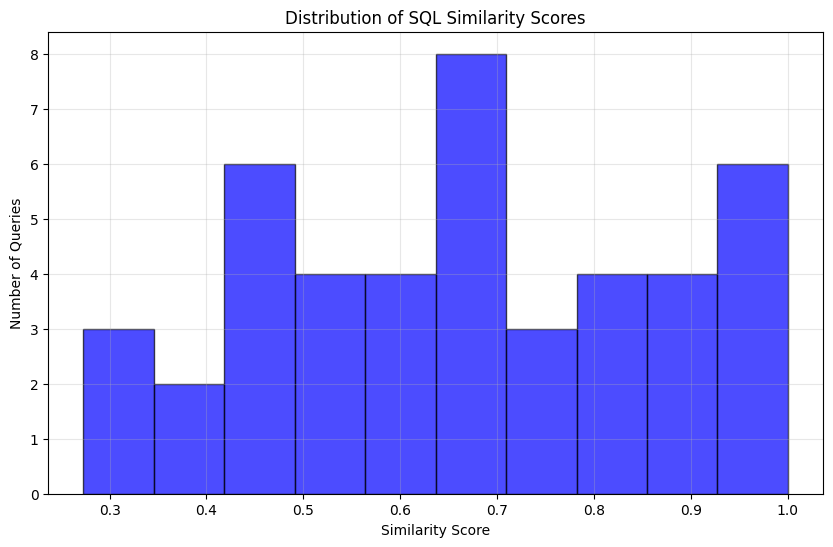

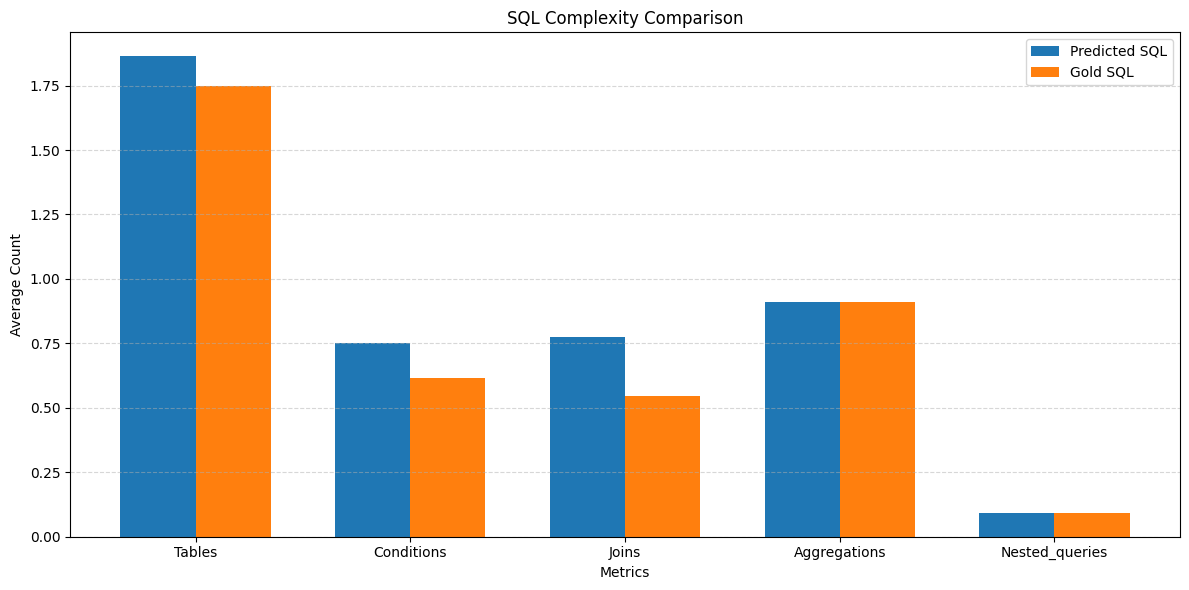

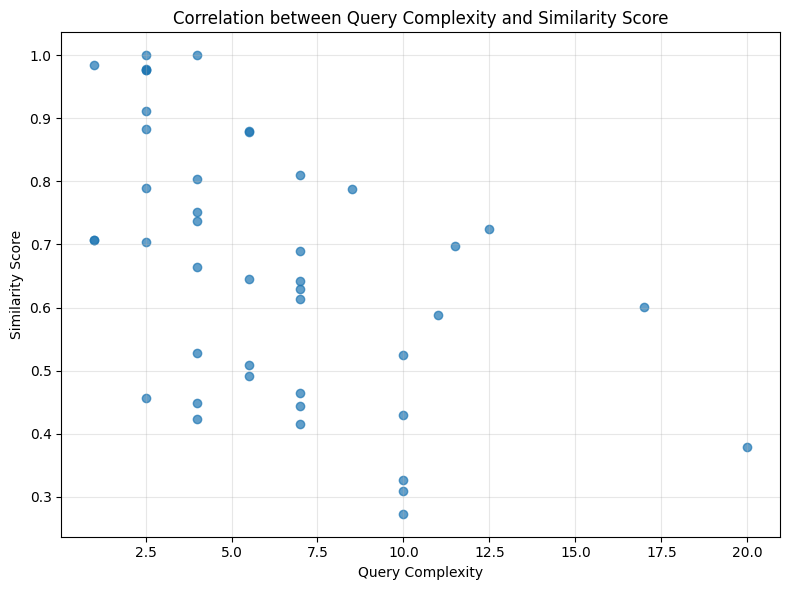


===== Detailed SQL Comparison Examples (44) =====

Example 1 (Similarity: 0.2730)
Database: wta_1
Question: List the names of all winners who played in both 2013 and 2016.

Translating: List the names of all winners who played in both 2013 and 2016.
Translation result: نام همه برندگانی که در سال های 2013 و 2016 بازی کرده اند را فهرست کنید.
Translated Question: نام همه برندگانی که در سال های 2013 و 2016 بازی کرده اند را فهرست کنید.

Similarity Score: 0.27
Exact Match: No

Normalized Predicted SQL:
SELECT DISTINCT p.first_name, p.last_name
FROM players p
JOIN matches m1 ON p.player_id = m1.winner_id
JOIN matches m2 ON p.player_id = m2.winner_id
WHERE m1.year = 2013 AND m2.year = 2016
ORDER BY p.last_name, p.first_name;

Normalized Gold SQL:
SELECT winner_name FROM matches WHERE YEAR  =  2013 INTERSECT SELECT winner_name FROM matches WHERE YEAR  =  2016

Component Differences:

SELECT_COLUMNS:

FROM_TABLES:

WHERE_CONDITIONS:

JOINS:
  Extra in Predicted: JOIN

Example 2 (Similarity: 0.3

Evaluating Spider examples:   0%|          | 0/50 [00:00<?, ?it/s]


Translating: Give the code of the airport with the least flights.
Translation result: کد فرودگاه با کمترین پرواز را بدهید.

Translating: Find number of pets owned by students who are older than 20.
Translation result: تعداد حیوانات خانگی دانش آموزانی که بیش از 20 سال سن دارند را پیدا کنید.

Translating: On average, when were the transcripts printed?
Translation result: به‌طور متوسط، تارنماها چه زمانی چاپ شدند؟

Translating: What are the distinct battle names which are between bulgarian commander 'Kaloyan' and latin commander 'Baldwin I'?
Translation result: نام‌های متمایز نبردهایی که بین فرمانده بلغاری 'کالویان' و فرمانده لاتین 'بالدوین یکم' رخ داده است چیست؟

Translating: List the first and last name of all players who are left / L hand in the order of birth date.
Translation result: لیست نام و نام خانوادگی تمام بازیکنانی که چپ دست / L hand هستند را بر اساس تاریخ تولد فهرست کنید.

Translating: Find the name of the shops that do not hire any employee.
Translation result: نام فروشگاه ه

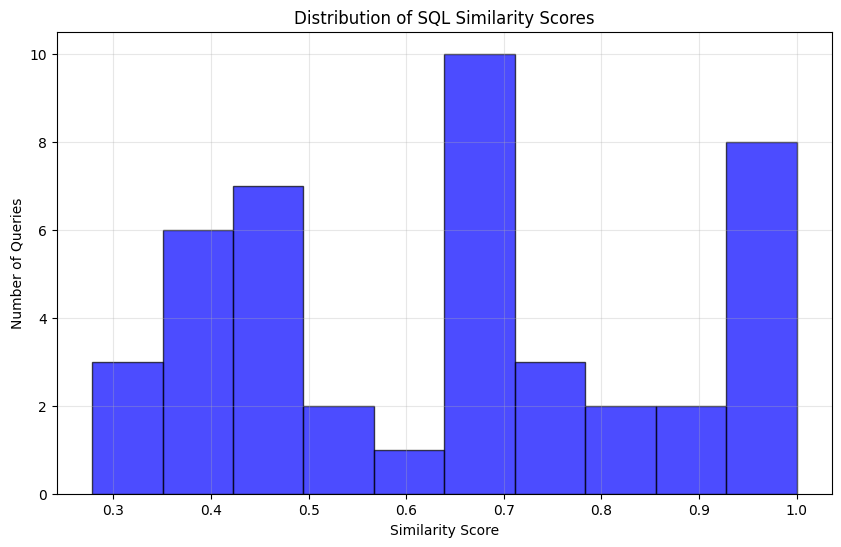

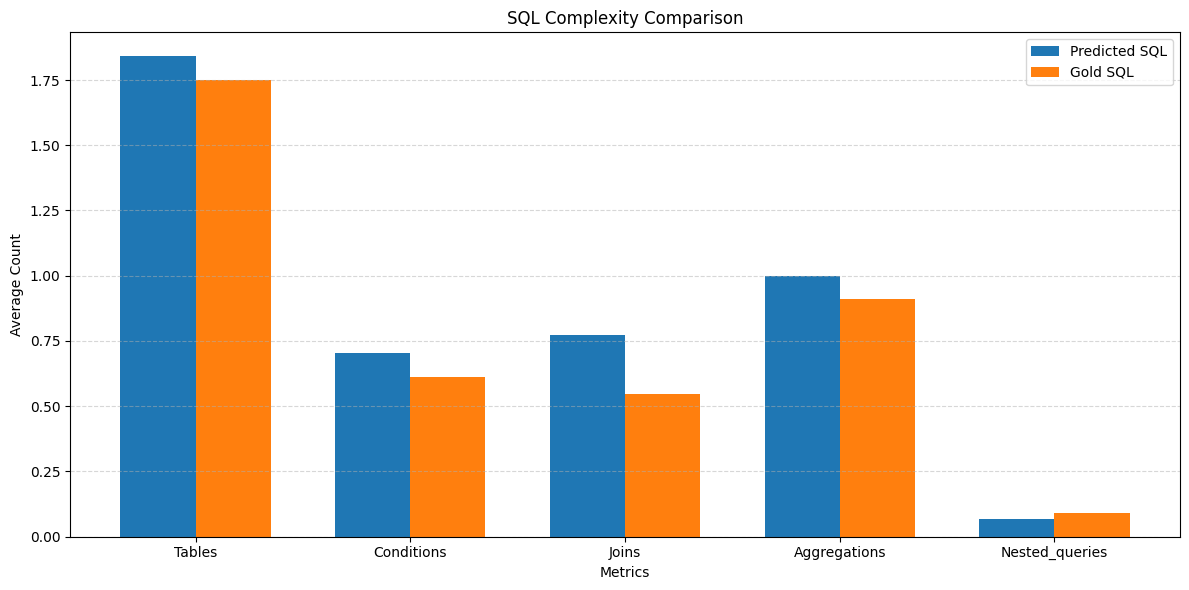

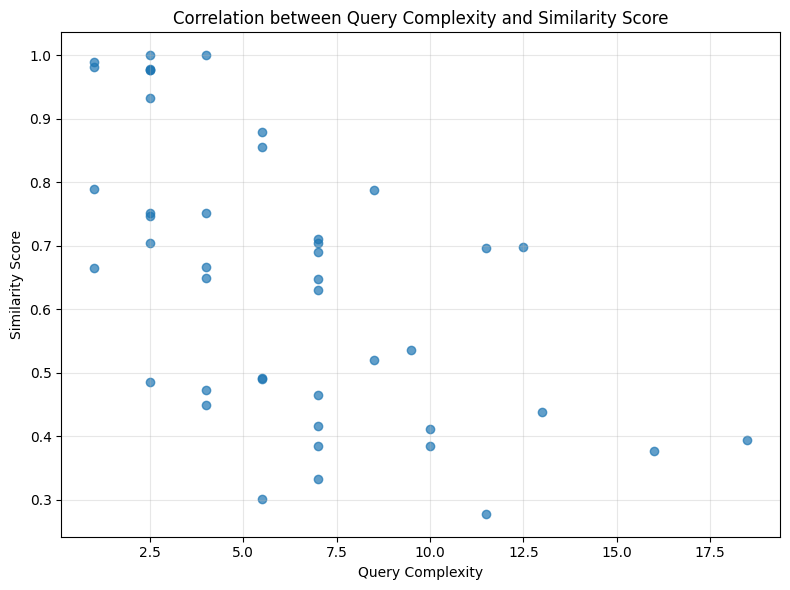


===== Detailed SQL Comparison Examples (44) =====

Example 1 (Similarity: 0.2783)
Database: wta_1
Question: What are the country code and first name of the players who won in both tourney WTA Championships and Australian Open?

Translating: What are the country code and first name of the players who won in both tourney WTA Championships and Australian Open?
Translation result: کد کشور و نام کوچک بازیکنانی که در هر دو تورنمنت قهرمانی WTA و آزاد استرالیا برنده شده‌اند چیست؟
Translated Question: کد کشور و نام کوچک بازیکنانی که در هر دو تورنمنت قهرمانی WTA و آزاد استرالیا برنده شده‌اند چیست؟

Similarity Score: 0.28
Exact Match: No

Normalized Predicted SQL:
SELECT DISTINCT p.country_code, p.first_name
FROM players p
JOIN matches m1 ON p.player_id = m1.winner_id
JOIN matches m2 ON p.player_id = m2.winner_id
WHERE m1.tourney_name ILIKE '%WTA%'
AND m2.tourney_name ILIKE '%Australian Open%'
AND m1.winner_id = m2.winner_id
ORDER BY p.first_name;

Normalized Gold SQL:
SELECT T1.country_code ,  

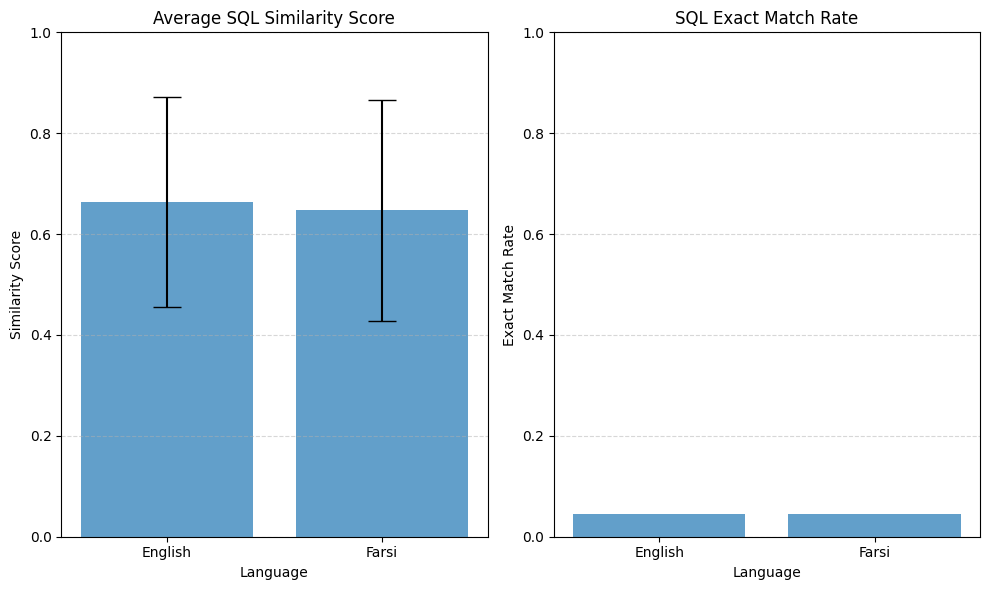


Found 44 questions tested in both languages with successful SQL generation

Direct comparison of SQL accuracy for same questions:
en_similarity    0.663393
fa_similarity    0.647548
en_exact         0.045455
fa_exact         0.045455
dtype: float64

Paired t-test for SQL similarity: t=0.8810, p=0.3832
No statistically significant difference in SQL similarity between English and Farsi.


In [10]:
num_result = 50

print("Running English evaluation with SQL parser...")
english_extended_results = run_extended_evaluation(sample_size=num_result, use_farsi=False)

detailed_sql_comparison_example(english_extended_results, num_examples=num_result)

print("Running Farsi evaluation with SQL parser...")
farsi_extended_results = run_extended_evaluation(sample_size=num_result, use_farsi=True)

detailed_sql_comparison_example(farsi_extended_results, num_examples=num_result)

print("\n===== English vs Farsi SQL Generation Comparison =====")

for r in english_extended_results:
    r['language'] = 'English'
for r in farsi_extended_results:
    r['language'] = 'Farsi'

all_results = english_extended_results + farsi_extended_results
df_combined = pd.DataFrame([r for r in all_results if r.get('success', False) and 'sql_similarity' in r])

if not df_combined.empty:
    metrics_by_lang = df_combined.groupby('language').agg({
        'sql_similarity': ['mean', 'std', 'count'],
        'sql_exact_match': 'mean'
    })
    
    print("\nSQL Similarity Metrics by Language:")
    print(metrics_by_lang)
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    lang_means = df_combined.groupby('language')['sql_similarity'].mean()
    lang_stds = df_combined.groupby('language')['sql_similarity'].std()
    
    plt.bar(lang_means.index, lang_means, yerr=lang_stds, capsize=10, alpha=0.7)
    plt.title('Average SQL Similarity Score')
    plt.xlabel('Language')
    plt.ylabel('Similarity Score')
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    
    # Bar chart for exact match rate
    plt.subplot(1, 2, 2)
    exact_match_rate = df_combined.groupby('language')['sql_exact_match'].mean()
    
    plt.bar(exact_match_rate.index, exact_match_rate, alpha=0.7)
    plt.title('SQL Exact Match Rate')
    plt.xlabel('Language')
    plt.ylabel('Exact Match Rate')
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Find common questions to compare directly
    english_dict = {r['question']: r for r in english_extended_results if r.get('success', False)}
    farsi_dict = {r['question']: r for r in farsi_extended_results if r.get('success', False)}
    
    common_questions = set(english_dict.keys()) & set(farsi_dict.keys())
    
    if common_questions:
        print(f"\nFound {len(common_questions)} questions tested in both languages with successful SQL generation")
        
        direct_comparison = []
        for question in common_questions:
            direct_comparison.append({
                'question': question,
                'en_similarity': english_dict[question].get('sql_similarity', 0),
                'fa_similarity': farsi_dict[question].get('sql_similarity', 0),
                'en_exact': english_dict[question].get('sql_exact_match', False),
                'fa_exact': farsi_dict[question].get('sql_exact_match', False),
            })
        
        df_direct = pd.DataFrame(direct_comparison)
        
        print("\nDirect comparison of SQL accuracy for same questions:")
        print(df_direct[['en_similarity', 'fa_similarity', 'en_exact', 'fa_exact']].mean())
        
        # Paired t-test to check for statistical significance
        from scipy import stats
        t_stat, p_val = stats.ttest_rel(df_direct['en_similarity'], df_direct['fa_similarity'])
        
        print(f"\nPaired t-test for SQL similarity: t={t_stat:.4f}, p={p_val:.4f}")
        if p_val < 0.05:
            print("The difference in SQL similarity between English and Farsi is statistically significant.")
        else:
            print("No statistically significant difference in SQL similarity between English and Farsi.")
else:
    print("Not enough data for English vs Farsi comparison")